# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
from fastai.text import *
from transformer_xl.default_txl import get_default_model
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
from fastai_data import *

In [5]:
import numpy as np
import torch.nn as nn

In [6]:
from ht_encode import *
import ht_encode

In [7]:
# bs=4
# bptt=64

bs=8
bptt=256

In [8]:
import fastai_data
fastai_data.Y_OFFSET=16

In [9]:
path = Path('data/midi/v7/midi_encode/np/hook_cont/')
ht_encode.config.continuous=True
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/all')

In [10]:
# loss_func = CrossEntropy with parts

In [11]:
class TransformerEmbed(nn.Module):
    def __init__(self, vocab_map, vocab_sizes, emb_dims, d_model, embed_p:float=0.1, **kwargs):
        super().__init__()
        # note, octave, duration, instrument
#         assert(sum(emb_dims) == d_model)
        self.vocab_map = vocab_map
        embeddings = []
        for in_d, out_d in zip(vocab_sizes, emb_dims):
            embeddings.append(nn.Embedding(in_d, out_d, padding_idx=PAD_IDX))
        self.embeddings = nn.ModuleList(embeddings)
        self.drop_emb = nn.Dropout(embed_p)
        
    def forward(self, x):
        # batch x bptt x (n,o,d,i)
        embs = []
        for i in range(x.shape[-1]):
            emb_idx = self.vocab_map[i]
            embs.append(self.embeddings[emb_idx](x[:,:,i]))
        emb = torch.cat(embs, dim=-1)
#         return emb
        return self.drop_emb(emb)

In [12]:
class TXLLinearDecoder(nn.Module):
    "To go on top of a RNNCore module and create a Language Model."
    initrange=0.1

    def __init__(self, n_out:int, n_hid:int, tie_encoder:nn.Module=None, bias:bool=True):
        super().__init__()
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight

    def forward(self, input):
        return self.decoder(input)

In [13]:
class TransformerDec(nn.Module):
    def __init__(self, txl_emb, vocab_map, output_p=0.0, out_bias=True, **kwargs):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        
        start_range = 0
        self.ranges = []
        decoders = []
        for i in range(len(vocab_map)):
            emb = txl_emb.embeddings[vocab_map[i]]
            decoder = TXLLinearDecoder(emb.num_embeddings, emb.embedding_dim, tie_encoder=emb, bias=out_bias)
            decoders.append(decoder)
            end_range = start_range+emb.embedding_dim
            self.ranges.append([start_range, end_range])
            start_range = end_range
            
        self.decoders = nn.ModuleList(decoders)
        
    def forward(self, input):
        raw_outputs, outputs = input
        output = self.output_dp(outputs[-1])
        res = []
        for dec,(start,end) in zip(self.decoders, self.ranges):
            res.append(dec(output[:,:,start:end]))
        return res, raw_outputs, outputs

In [14]:

class LMNPTransformerXL(nn.Module):
    "TransformerXL model: https://arxiv.org/abs/1901.02860."
    def __init__(self, encoder, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=False, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadRelativeAttention,
                 learned_pos_enc:bool=False, mask:bool=True, mem_len:int=0, **kwargs):
        super().__init__()
        self.encoder = encoder
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.u = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.v = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.mem_len,self.n_layers,self.d_model,self.mask = mem_len,n_layers,d_model,mask
        if self.mem_len > 0: self.reset()
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                      attn_cls=attn_cls) for k in range(n_layers)])
    
    def reset(self):
        "Reset the internal memory."
        self.hidden = [next(self.parameters()).data.new(0) for i in range(self.n_layers+1)]
#         self.hidden = [next(self.parameters()).data.new(0).cuda() for i in range(self.n_layers+1)]

    def _update_mems(self, hids):
        if not getattr(self, 'hidden', False): return None
        assert len(hids) == len(self.hidden), 'len(hids) != len(self.hidden)'
        with torch.no_grad():
            for i in range(len(hids)):
                cat = torch.cat([self.hidden[i], hids[i]], dim=1)
                self.hidden[i] = cat[:,-self.mem_len:].detach()
    
    def select_hidden(self, idxs): self.hidden = [h[idxs] for h in self.hidden]
    
    def forward(self, x):
        bs,x_len,_ = x.size()
        inp = self.encoder(x)
        m_len = self.hidden[0].size(1) if hasattr(self, 'hidden') and len(self.hidden[0].size()) > 1 else 0
        seq_len = m_len + x_len
        mask = torch.triu(x.new_ones(x_len, seq_len), diagonal=1+m_len).byte()[None,None] if self.mask else None
        #[None,:,:None] for einsum implementation of attention
        hids = []
        pos = torch.arange(seq_len-1, -1, -1, device=inp.device, dtype=inp.dtype)
        pos_enc = self.pos_enc(pos)
        hids.append(inp)
        for i, layer in enumerate(self.layers):
            mem = self.hidden[i] if self.mem_len > 0 else None
            inp = layer(inp, r=pos_enc, u=self.u, v=self.v, mask=mask, mem=mem)
            hids.append(inp)
        core_out = inp[:,-x_len:]
        if self.mem_len > 0 : self._update_mems(hids)
        return (self.hidden if self.mem_len > 0 else [core_out]),[core_out]

In [15]:
config = tfmerXL_lm_config

In [16]:
PAD_IDX=ht_encode.config.pad_idx+ht_encode.config.enc_offset
# must remember to add 1 to tensors

In [17]:
train_ids_file = path/'tmp/all/train_ids.npy'
all_ids = np.load(train_ids_file)
id_cat = np.concatenate(all_ids); id_cat.shape
max_vocab = id_cat.max(axis=0)
max_vocab = (max_vocab+1).tolist(); max_vocab

[15, 13, 5, 15, 15, 15, 15, 5, 7, 12]

In [18]:
min_vocab = id_cat.min(axis=0); min_vocab

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [19]:
idx2embidx = {
    0:0,1:1,2:2,
    3:0,4:0,5:0,6:0,7:2,
    8:3,
    9:4
}

In [20]:
max_vocab_sizes = [max_vocab[i] for i in [0,1,2,8,9]]

In [21]:
emb_dims = [100,100,100,20,20]

In [22]:
idx2dims = {k:(max_vocab_sizes[v],emb_dims[v]) for k,v in idx2embidx.items()}; idx2dims

{0: (15, 100),
 1: (13, 100),
 2: (5, 100),
 3: (15, 100),
 4: (15, 100),
 5: (15, 100),
 6: (15, 100),
 7: (5, 100),
 8: (7, 20),
 9: (12, 20)}

In [23]:
config['vocab_sizes'] = max_vocab_sizes
config['vocab_map'] = idx2embidx

In [24]:
config['emb_dims'] = emb_dims
total_embs = sum([i[1] for i in  idx2dims.values()])
config['d_model'] = total_embs

In [25]:
config['ctx_len'] = 0
config['mem_len'] = 256
config['d_inner'] = 1024

In [26]:
# config['mem_len'] = 0
# config['d_inner'] = 512

In [27]:
config

{'ctx_len': 0,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 840,
 'd_head': 41,
 'd_inner': 1024,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 256,
 'mask': True,
 'vocab_sizes': [15, 13, 5, 7, 12],
 'vocab_map': {0: 0, 1: 1, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 2, 8: 3, 9: 4},
 'emb_dims': [100, 100, 100, 20, 20]}

In [28]:
def get_language_model(config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    init = config.pop('init') if 'init' in config else None
    
    embed = TransformerEmbed(**config)
    txl = LMNPTransformerXL(embed, **config)
    decoder = TransformerDec(embed, **config)
    model = SequentialRNN(txl, decoder).cuda()
    
    return model if init is None else model.apply(init)


def language_model_learner(data:DataBunch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(config=config, drop_mult=drop_mult)
    learn = LanguageLearner(data, model, split_func=tfmer_lm_split, **learn_kwargs)
    return learn

In [29]:

class LMNPLoss(nn.Module):
    "Same as `func`, but flattens input and target."
    def __init__(self):
        super().__init__()
        self.fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX) 
        # not using func otherwise _loss_func_name2activ uses this attribute to get cross entropy loss

    def __repr__(self): return f"numpyenc loss of {self.fn}"

    def forward(self, inputs:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        losses = []
        for idx,input in enumerate(inputs):
            if idx in BIDX_ALL: continue
            t = target[:,:,idx]
            input = input.view(-1,input.shape[-1])
            losses.append(self.fn(input, t.view(-1)))
        return sum(losses)

In [30]:
test = []
accs = []
inps = []
tgs = []

In [31]:
def lmnp_accuracy(inputs:Tensor, target:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    target = target[:,:,:-2]
    inputs = [i.argmax(dim=-1).unsqueeze(dim=-1) for i in inputs[:-2]]
    input_cat = torch.cat(inputs, dim=-1).cpu().numpy()
    target = target.cpu().numpy()
    acc = (input_cat==target).astype(float)
    acc[target==PAD_IDX] = np.nan
#     test.append(np.nanmean(acc, dtype=float, axis=(0,1)))
#     accs.append(acc)
#     inps.append(input_cat)
#     tgs.append(target)
    return torch.tensor(np.nanmean(acc, dtype=float))

In [33]:
# learn.validate()

In [34]:
learn = language_model_learner(data, config, clip=0.25, loss_func=LMNPLoss(), metrics=[lmnp_accuracy])

In [35]:
# clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()# 

In [36]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,lmnp_accuracy
1,10.870396,10.676178,0.559446
2,9.037024,9.024712,0.633703
3,8.667953,8.585174,0.655611
4,8.340823,8.320344,0.665299
5,7.973134,8.114388,0.674027
6,7.891608,7.999819,0.676713
7,7.488433,7.917306,0.679658
8,7.196436,7.881710,0.681492
9,7.009666,7.909926,0.682549
10,6.991349,7.892411,0.682930


In [37]:
learn.save('predict_n16')

In [38]:
from fastai import basic_train

In [39]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [40]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [49]:
tsteps = fastai_data.Y_OFFSET

In [66]:
def predict(self, xb, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
            decoder=decode_spec_tokens):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    if xb.shape[0] > 1: xb = xb[0][None]
    yb = torch.ones_like(xb)
    new_idx = []
    for _ in range(n_words): #progress_bar(range(n_words), leave=False):
        block = []
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            timesteps = []
            last_n = item[0][-tsteps:]
            for res in last_n:
                if min_p is not None: 
                    if (res >= min_p).float().sum() == 0:
                        warn(f"There is no item with probability >= {min_p}, try a lower value.")
                    else: res[res < min_p] = 0.
                if temperature != 1.: res.pow_(1 / temperature)
                idx = torch.multinomial(res, 1).item()
                timesteps.append(idx)
            block.append(timesteps)
        new_idx.append(np.array(block).transpose())
        xb = xb.new_tensor(block).view(1,tsteps,-1)
    return new_idx


In [67]:
xb,yb = learn.data.one_batch(cpu=False)

In [68]:
out = predict(learn, xb, n_words=5)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/aten/src/THC/generic/THCTensorMath.cu:14

In [64]:
np.array(out)

array([[[12,  9,  4,  3, ...,  7,  4,  3,  4],
        [ 8,  7,  3,  8, ...,  3,  4,  6,  8],
        [ 8,  7,  4,  8, ...,  7,  4,  4,  8],
        [10,  7,  3,  8, ...,  3,  4,  3, 10],
        ...,
        [ 7,  7,  4,  3, ..., 14,  4,  0,  2],
        [ 3,  7,  4, 14, ...,  5,  4,  3,  8],
        [14,  9,  4,  7, ..., 12,  4,  4, 10],
        [ 1,  8,  3, 10, ...,  3,  3,  5,  9]]])

In [44]:
song = dec_arr(np.array(out)); song

Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustained note with out a hit. Removing all
Broken encoding. Sustain

Part[0]:
[Chords]:
B(abs=0.25:dur=0.5) C([[sd=6:oct=0, sd=1:oct=1, sd=4:oct=1, sd=5:oct=1]])
B(abs=3.75:dur=2.5) C([[sd=6:oct=0, sd=1:oct=1, sd=4:oct=1, sd=5:oct=1]])
B(abs=8.0:dur=0.25) C([[sd=6:oct=0, sd=2:oct=1, sd=3:oct=1, sd=5#:oct=1]])

[Notes]:
B(abs=1.5:dur=0.25) P(sd=5:oct=6)
B(abs=2.25:dur=0.25) P(sd=6:oct=6)
B(abs=7.0:dur=0.25) P(sd=6:oct=5)
B(abs=8.0:dur=0.25) P(sd=6:oct=5)
B(abs=11.25:dur=0.5) P(sd=2:oct=6)
B(abs=13.5:dur=0.25) P(sd=6:oct=6)
B(abs=13.75:dur=0.25) P(sd=4#:oct=3)



HMetadata(title='decoded', BPM='120', beats_in_measure='4', key='C', mode='1')

In [45]:
stream = song.to_stream()

In [46]:
stream.show('text')

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.stream.Part 0x7f2d0c6a4dd8>
    {0.0} <music21.stream.Part 0x7f2d0c6a4cf8>
        {1.5} <music21.note.Note G>
        {2.25} <music21.note.Note A>
        {7.0} <music21.note.Note A>
        {8.0} <music21.note.Note A>
        {11.25} <music21.note.Note D>
        {13.5} <music21.note.Note A>
        {13.75} <music21.note.Note F#>
{0.0} <music21.stream.Part 0x7f2d0c6a4da0>
    {0.0} <music21.stream.Part 0x7f2d0c6a4358>
        {0.25} <music21.chord.Chord A2 C3 F3 G3>
        {3.75} <music21.chord.Chord A2 C3 F3 G3>
        {8.0} <music21.chord.Chord A2 D3 E3 G#3>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>


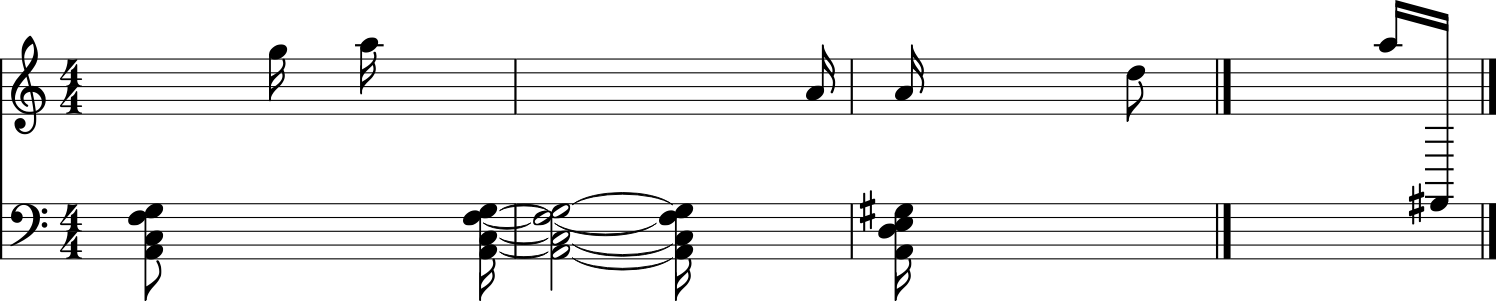

In [47]:
stream.show()

In [48]:
stream.show('midi')